<a href="https://colab.research.google.com/github/megan0422/DABPFinalProject/blob/main/Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np 
!pip install gurobipy
import gurobipy as gp
from gurobipy import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
# NBI data
url = 'https://raw.githubusercontent.com/megan0422/DABPFinalProject/main/PA22%20-%20PA22.csv'
PA22 = pd.read_csv(url)
# Extract data on allegheny county from the whole dataset
PA22_allegheny  = PA22[PA22["COUNTY_CODE_003"] == 3]
PA22_allegheny  = PA22_allegheny[PA22_allegheny["MAINTENANCE_021"] == 2]
PA22_allegheny

,STATE_CODE_001,STRUCTURE_NUMBER_008,RECORD_TYPE_005A,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,ROUTE_NUMBER_005D,DIRECTION_005E,HIGHWAY_DISTRICT_002,COUNTY_CODE_003,PLACE_CODE_004,...,BRIDGE_LEN_IND_112,SCOUR_CRITICAL_113,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,MIN_NAV_CLR_MT_116,FED_AGENCY,SUBMITTED_BY,BRIDGE_CONDITION,LOWEST_RATING,DECK_AREA
496,42,1310,1,3,1,885,0,11,3,61000,...,Y,8,13307,2032,0.0,N,42,F,5,15885.73
780,42,2114,1,4,0,0,0,11,3,15216,...,Y,4,16740,2028,0.0,N,42,F,6,835.24
782,42,2120,1,8,0,0,0,11,3,17048,...,Y,8,50,2023,0.0,N,42,F,5,47.95
783,42,2129,1,4,1,0,0,11,3,21024,...,Y,4,1899,2025,0.0,N,42,P,4,81.34
788,42,2135,1,3,0,2020,0,11,3,23000,...,Y,8,4381,2025,0.0,N,42,F,6,2234.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22075,42,54464,1,5,0,0,0,11,3,69584,...,Y,8,5166,2036,0.0,N,42,G,9,264.12
22481,42,56656,1,5,1,0,0,11,3,75816,...,Y,N,18000,2025,NaN,N,42,G,8,476.28
22633,42,57085,1,5,1,0,0,11,3,36808,...,Y,8,550,2042,0.0,N,42,G,7,127.05
22781,42,57402,1,4,2,0,0,11,3,72160,...,Y,8,1124,2038,0.0,N,42,G,8,182.28


In [51]:
PA22_allegheny = PA22_allegheny[["STRUCTURE_NUMBER_008","DETOUR_KILOS_019","ADT_029","STRUCTURE_LEN_MT_049","TOTAL_IMP_COST_096","HIGHWAY_SYSTEM_104","PERCENT_ADT_TRUCK_109","BRIDGE_CONDITION"]]
PA22_allegheny_cost_nonzero = PA22_allegheny[PA22_allegheny["TOTAL_IMP_COST_096"] != 0]
PA22_allegheny_cost_nonzero_dummy = pd.get_dummies(PA22_allegheny_cost_nonzero,columns=["BRIDGE_CONDITION"])
PA22_allegheny_cost_nonzero_dummy['Count'] = 1
PA22_allegheny_cost_nonzero_dummy_na = PA22_allegheny_cost_nonzero_dummy.dropna()
PA22_allegheny_cost_nonzero_dummy_na

,STRUCTURE_NUMBER_008,DETOUR_KILOS_019,ADT_029,STRUCTURE_LEN_MT_049,TOTAL_IMP_COST_096,HIGHWAY_SYSTEM_104,PERCENT_ADT_TRUCK_109,BRIDGE_CONDITION_F,BRIDGE_CONDITION_G,BRIDGE_CONDITION_P,Count
780,2114,6,9615,62.8,302.0,1,4.0,1,0,0,1
782,2120,159,40,13.7,55.0,0,1.0,1,0,0,1
783,2129,10,1899,9.8,113.0,0,5.0,0,0,1,1
789,2144,6,3288,6.4,82.0,0,5.0,1,0,0,1
794,2160,2,6300,12.5,157.0,0,5.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1084,2721,16,4813,9.8,72.0,0,5.0,0,0,1,1
1085,2723,3,11414,129.8,359.0,1,5.0,1,0,0,1
1086,2724,10,408,15.2,376.0,0,1.0,1,0,0,1
1087,2727,11,3549,6.4,99.0,0,5.0,1,0,0,1


In [52]:
i = len(PA22_allegheny_cost_nonzero_dummy_na)
bridge = range(i)

# Step 0. Set up the model
model = Model()

# Step 1. Set up the decision variables
x = model.addVars(bridge, vtype=GRB.BINARY)

addtr = (PA22_allegheny_cost_nonzero_dummy_na["PERCENT_ADT_TRUCK_109"].to_numpy())/100
adt = PA22_allegheny_cost_nonzero_dummy_na["ADT_029"].to_numpy()
hwy = PA22_allegheny_cost_nonzero_dummy_na["HIGHWAY_SYSTEM_104"].to_numpy()
bl = PA22_allegheny_cost_nonzero_dummy_na["STRUCTURE_LEN_MT_049"].to_numpy()
drt = PA22_allegheny_cost_nonzero_dummy_na["DETOUR_KILOS_019"].to_numpy()*1000

#Step 2. Set up the objective function
T = (addtr*adt/24*32*1 + addtr*adt/24*16.2*1.67)*24*365*(drt-bl)
V = (addtr*adt/24*bl*hwy*50*(3.02+0.94) +addtr*adt/24*bl*(1-hwy)*25*(3.02+0.45)+(1-addtr)*adt/24*bl*hwy*50*(3.02+0.45) +(1-addtr)*adt/24*bl*(1-hwy)*25*(3.02+0.45))*24*365*(drt-bl)

model.setObjective (sum((T[i]+V[i])*x[i] for i in bridge))
model.modelSense = GRB.MAXIMIZE

#Step 3. Set up the constraints
#budget constraint
C = PA22_allegheny_cost_nonzero_dummy_na["TOTAL_IMP_COST_096"].to_numpy()*1000
B = 24000000
dummy_p = PA22_allegheny_cost_nonzero_dummy_na["BRIDGE_CONDITION_P"].to_numpy()
count_var = PA22_allegheny_cost_nonzero_dummy_na['Count'].to_numpy()

model.addConstr(sum(C[i]*x[i] for i in bridge) <= B) 
model.addConstr(sum(dummy_p[i]*x[i] for i in bridge) >= (sum(count_var[i]*x[i] for i in bridge))/2) 

model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 2 rows, 98 columns and 196 nonzeros
Model fingerprint: 0xba39f982
Variable types: 0 continuous, 98 integer (98 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+08]
  Objective range  [5e+10, 2e+16]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+07, 2e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 8.294253e+14
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 2 rows, 97 columns, 194 nonzeros
Variable types: 0 continuous, 97 integer (97 binary)
Found heuristic solution: objective 1.326852e+16

Root relaxation: objective 3.206215e+16, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |  

In [53]:
decision_variable = []
for v in model.getVars():
    decision_variable.append(v.x)
print("Total cost is", np.nansum(np.array(decision_variable)*C))

Total cost is 24000000.0


In [54]:
structure_number_with_zero = np.array(decision_variable)*PA22_allegheny_cost_nonzero_dummy_na["STRUCTURE_NUMBER_008"].to_numpy().astype(int) 
structure_number = structure_number_with_zero[structure_number_with_zero != 0] 
bridge_number = len(structure_number) 
print(bridge_number, "bridges should be repair/replacement") 
print("The STRUCTURE NUMBER of the bridges to repair/replace are",structure_number) 

22 bridges should be repair/replacement
The STRUCTURE NUMBER of the bridges to repair/replace are [2114. 2129. 2168. 2179. 2192. 2204. 2206. 2232. 2251. 2259. 2310. 2334.
 2388. 2579. 2580. 2632. 2663. 2666. 2692. 2714. 2721. 2723.]


In [57]:
selected = PA22_allegheny_cost_nonzero_dummy_na.query('STRUCTURE_NUMBER_008 == ["2114","2129","2168","2179","2192","2204","2206","2232","2251","2259","2310","2334","2388","2579","2580","2632","2663","2666","2692","2714","2721","2723"]')
selected.describe()

,DETOUR_KILOS_019,ADT_029,STRUCTURE_LEN_MT_049,TOTAL_IMP_COST_096,HIGHWAY_SYSTEM_104,PERCENT_ADT_TRUCK_109,BRIDGE_CONDITION_F,BRIDGE_CONDITION_G,BRIDGE_CONDITION_P,Count
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.00000,22.000000,22.000000,22.000000,22.0
mean,8.181818,9958.090909,131.368182,1090.909091,0.318182,6.50000,0.409091,0.090909,0.500000,1.0
std,4.895444,8627.439701,203.865124,3118.092593,0.476731,6.55199,0.503236,0.294245,0.511766,0.0
min,2.000000,155.000000,7.600000,56.000000,0.000000,1.00000,0.000000,0.000000,0.000000,1.0
25%,3.750000,2627.500000,14.000000,82.250000,0.000000,4.25000,0.000000,0.000000,0.000000,1.0
50%,6.000000,8021.500000,19.050000,110.000000,0.000000,5.00000,0.000000,0.000000,0.500000,1.0
75%,12.250000,15156.000000,210.500000,638.000000,1.000000,5.00000,1.000000,0.000000,1.000000,1.0
max,19.000000,26416.000000,739.400000,14713.000000,1.000000,30.00000,1.000000,1.000000,1.000000,1.0


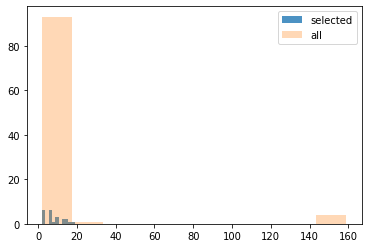

In [58]:
a = selected["DETOUR_KILOS_019"].values.tolist()
b = PA22_allegheny_cost_nonzero_dummy_na["DETOUR_KILOS_019"].values.tolist()
plt.hist(a, alpha = 0.8, label='selected')
plt.hist(b, alpha = 0.3, label='all')
plt.legend(loc='upper right')
plt.show()

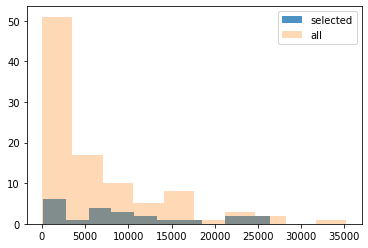

In [59]:
a = selected["ADT_029"].values.tolist()
b = PA22_allegheny_cost_nonzero_dummy_na["ADT_029"].values.tolist()
plt.hist(a, alpha = 0.8, label='selected')
plt.hist(b, alpha = 0.3, label='all')
plt.legend(loc='upper right')
plt.show()

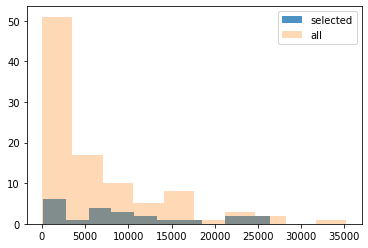

In [60]:
a = selected["ADT_029"].values.tolist()
b = PA22_allegheny_cost_nonzero_dummy_na["ADT_029"].values.tolist()
plt.hist(a, alpha = 0.8, label='selected')
plt.hist(b, alpha = 0.3, label='all')
plt.legend(loc='upper right')
plt.show()

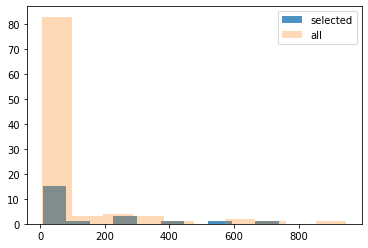

In [61]:
a = selected["STRUCTURE_LEN_MT_049"].values.tolist()
b = PA22_allegheny_cost_nonzero_dummy_na["STRUCTURE_LEN_MT_049"].values.tolist()
plt.hist(a, alpha = 0.8, label='selected')
plt.hist(b, alpha = 0.3, label='all')
plt.legend(loc='upper right')
plt.show()

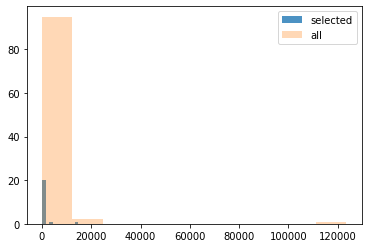

In [62]:
a = selected["TOTAL_IMP_COST_096"].values.tolist()
b = PA22_allegheny_cost_nonzero_dummy_na["TOTAL_IMP_COST_096"].values.tolist()
plt.hist(a, alpha = 0.8, label='selected')
plt.hist(b, alpha = 0.3, label='all')
plt.legend(loc='upper right')
plt.show()